Microbenchmark corresponds to
Figures 6(a,b) 7(a,b) 8(a,b) 9(a,b) 10(a,b) 16(a,b) 17(a,b) 18(a,b) in our paper.
This notebook reproduces the graphs correspond to Figures 6(a,b) 7(a,b) 16(a,b) 17(a,b).
Other figures are included in another multiple-block notebook.

This notebook doesn't aim to rerun the whole experiment, as it takes long to finish.
Instead, it reads saved experiment result from the directory, and reproduces figures in our paper.

In [9]:
#  download and unzip dataset
!mkdir dataset_release
!wget --directory-prefix=dataset_release "https://github.com/taoluo/privacy-budget-scheduling/releases/download/microbench-data/single_block.tar.gz"
!tar -xzf ./dataset_release/single_block.tar.gz --directory ./dataset_release

mkdir: cannot create directory ‘dataset_release’: File exists
--2021-06-25 20:03:12--  https://github.com/taoluo/privacy-budget-scheduling/releases/download/microbench-data/single_block.tar.gz
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
Unable to establish SSL connection.


In [10]:
import pandas as pd

from dpsched.analysis.data_collection import workspace2dataframe
from dpsched.analysis.plot import plot_granted_tasks, plot_delay_cdf
from dpsched.utils.configs import DpPolicyType
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'

In [11]:
# read experiment result from the directory, form a dataframe.

workspace_file = "workspace_06-25-05H-51-50"
workspace_dir = "./dataset_release/%s" % workspace_file
table = workspace2dataframe(workspace_dir)
table.columns

/home/tao2/miniconda3/envs/pypy/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Index(['blocks_mice_fraction', 'epsilon_mice_fraction', 'arrival_interval',
       'policy', 'lifetime', 'sim_index', 'task_amount_N', 'task_timeout',
       'is_rdp', 'granted_tasks_total', 'num_granted_tasks_l_dp_l_blk',
       'num_granted_tasks_l_dp_s_blk', 'num_granted_tasks_s_dp_l_blk',
       'num_granted_tasks_s_dp_s_blk', 'granted_tasks_per_10sec',
       'sim_duration', 'grant_delay_P50', 'grant_delay_P99', 'grant_delay_avg',
       'grant_delay_max', 'grant_delay_min', 'dp_allocation_duration_list',
       'N_or_T_based', 'N_', 'N_or_T_'],
      dtype='object')

/home/tao2/miniconda3/envs/pypy/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Index(['blocks_mice_fraction', 'epsilon_mice_fraction', 'arrival_interval',
       'policy', 'lifetime', 'sim_index', 'task_amount_N', 'task_timeout',
       'is_rdp', 'granted_tasks_total', 'num_granted_tasks_l_dp_l_blk',
       'num_granted_tasks_l_dp_s_blk', 'num_granted_tasks_s_dp_l_blk',
       'num_granted_tasks_s_dp_s_blk', 'granted_tasks_per_10sec',
       'sim_duration', 'grant_delay_P50', 'grant_delay_P99', 'grant_delay_avg',
       'grant_delay_max', 'grant_delay_min', 'dp_allocation_duration_list',
       'N_or_T_based', 'N_', 'N_or_T_'],
      dtype='object')

## How to interpret a graph / how the subgraphs are organized
Each plot calls seaborn's `relplot()` under the hood.

Considering plotting a multi-dimensional dataset.
There are x-dimension and y-dimension: a plot reproduces n x m subplots, where subplots share the same two dataset dimensions as their x axis and y axis.
There are also row-dimension and column-dimension: Different data points are grouped by their other row-dimension and column-dimension into different

Take the following first graph as example,
The x-dimension is `N_or_T_`, and the y-dimension is number of granted pipelines. In each subplot, we plot a curve of granted pipeline amount as a function of `N_or_T_`.
(N.B. N is number of arrived tasks, T is block's lifetime. they are the parameters of scheduling policies)
The row-dimension is `is_rdp`, meaning whether a data point corresponds to a scheduling policy with Renyi DP composition.
Column-dimension is `N_or_T_based`, meaning whether a data point corresponds to a scheduling policy with task-arrival based RDP/DP unlocking or time interval based RDP/DP unlocking.
The first-come-first-server(FCFS) baseline is neither T nor N based. Nevertheless, we plot it in every subplot for better visualization.
In particular, if a subgrah has a subtitle as "id_rdp = False | N_or_T_based= N", it reproduces policies with traditional epsilon-delta composition and N-based unlocking, e.g., RR-N and DPF-N.

Following graph reproduces
 -  fig 6(a) DPF behavior on a single block - Number of pipelines allocated.
 -  fig 16(a) Rényi DPF behavior on a single block. - Number of pipelines allocated.

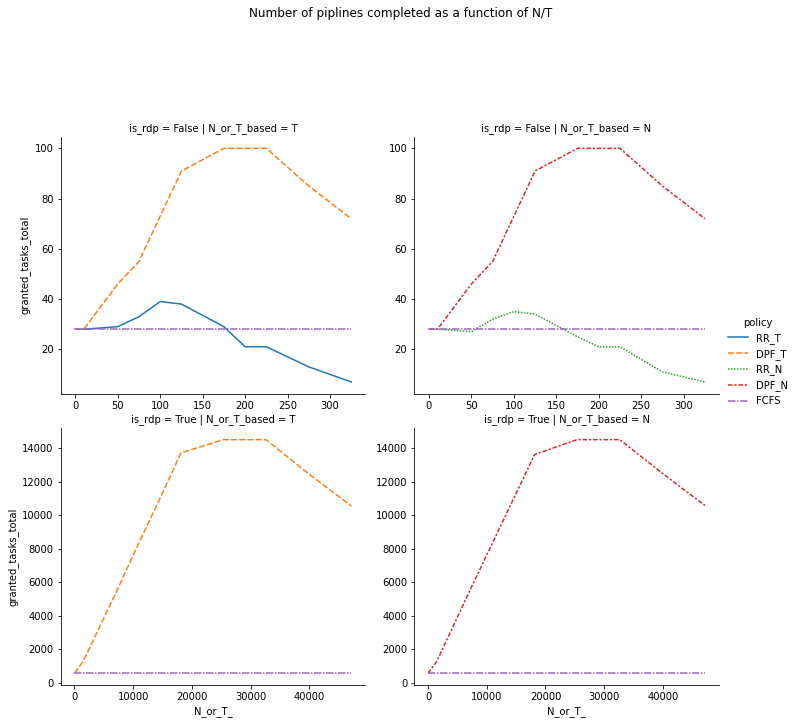

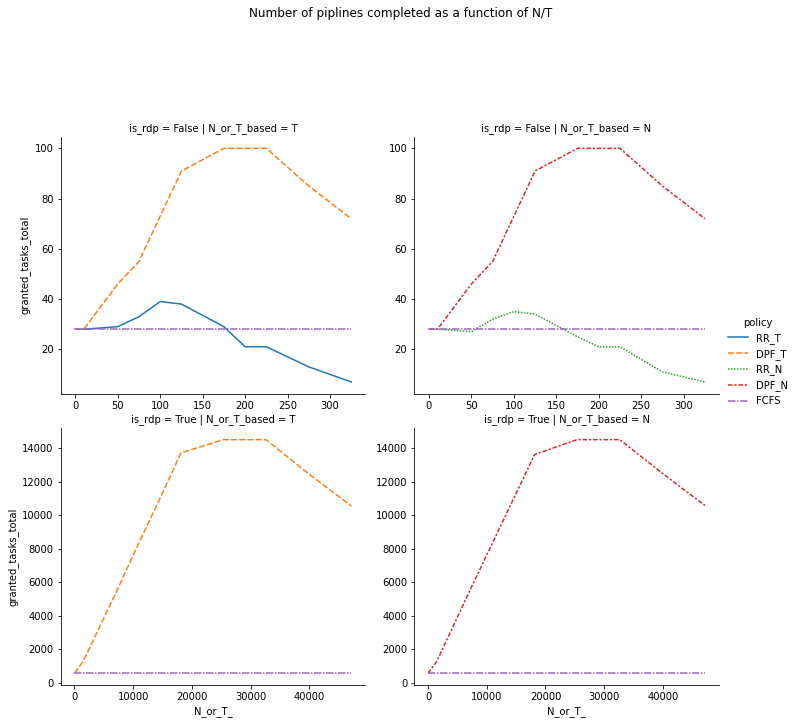

In [12]:
title = "Number of piplines completed as a function of N/T"
table1 = table.loc[(table['epsilon_mice_fraction'] == 75)]

## extend FCFS data ponits into horizontal lines in different subplots.
fcfs_padding_list = []
fcfs_padding = table1[table1.policy == DpPolicyType.DP_POLICY_FCFS.value]
for N_or_T_based in ('N', 'T'):
    for is_rdp in (True, False):
        left = fcfs_padding[(fcfs_padding.is_rdp==is_rdp)].copy()
        left.N_or_T_ = -1
        left.N_or_T_based = N_or_T_based
        fcfs_padding_list.append(left)

        right = left.copy()
        max_N_or_T = max(table1[(table1.N_or_T_based == N_or_T_based) & (table1.is_rdp ==is_rdp) ].N_or_T_)
        right.N_or_T_ = max_N_or_T
        right.N_or_T_based = N_or_T_based
        # if not is_rdp:
        #     print(N_or_T_based)
        #     print(max_N_or_T)

        fcfs_padding_list.append(right)
table1_1 = pd.concat([table1] + fcfs_padding_list, axis=0)

plot_granted_tasks(save_file_name="figure1.pdf", table=table1_1, title=title, xaxis_col='N_or_T_',
                   yaxis_col='granted_tasks_total')


Following graph reproduces
 - fig 6(b) DPF behavior on a single block - Pipeline Scheduling Delay
 - fig 16(b) Rényi DPF behavior on a single block. - Pipeline Scheduling Delay

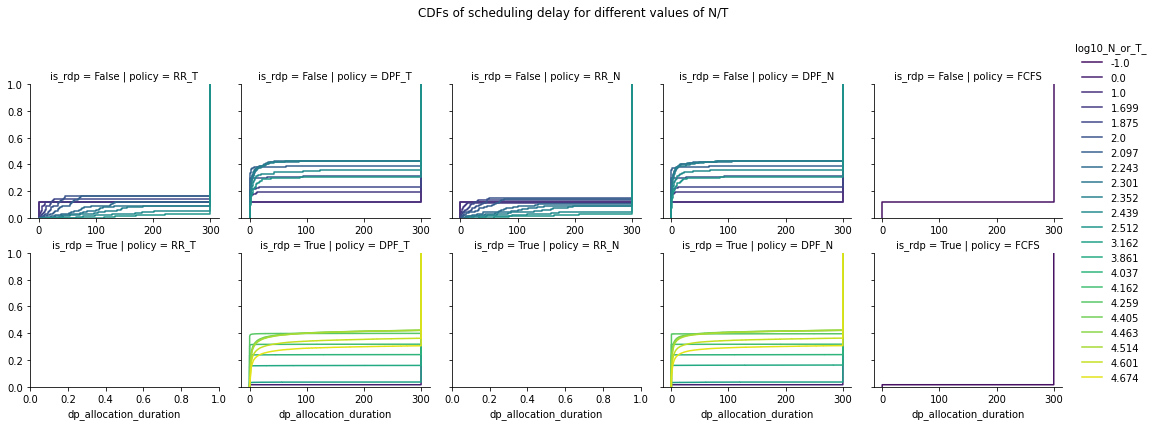

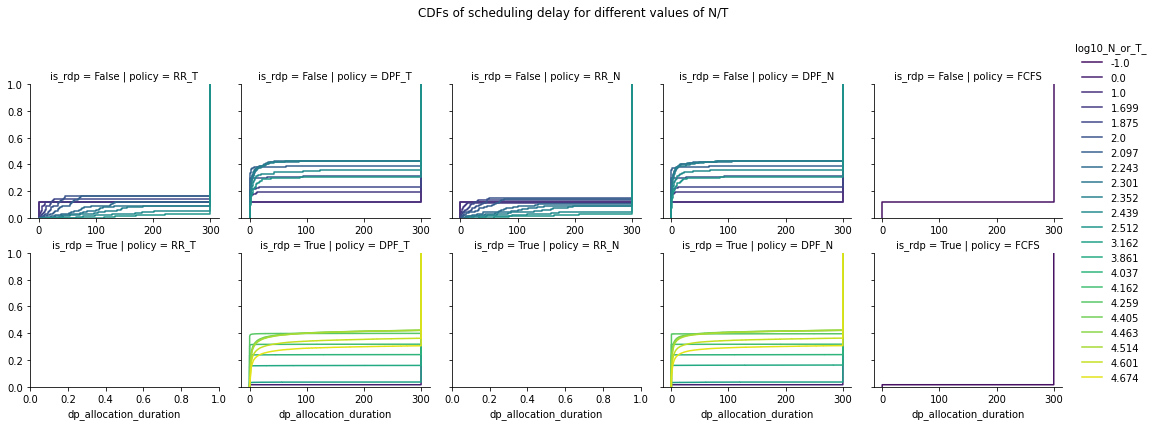

In [13]:
title = 'CDFs of scheduling delay for different values of N/T'
should_modify_alloc_duration = True  # immediate rejection's delay is treated as timeout
should_plot_granted = False
should_exclude_late_task = False  # exclude tasks arrived late
delay_lst_column = 'dp_allocation_duration_list'
plot_delay_cdf(table1, delay_lst_column, 'N_or_T_', 'figure2.pdf', should_exclude_late_task,
               should_modify_timeout_duration=True, task_timeout=300, plot_title=title)


Following graph reproduces
 - fig 7(a) DPF with varied workload mix, single block. - Number of pipelines allocated.
 - fig 17(a) Rényi DPF behavior with variable workload mix, single block. - Number of pipelines allocated.

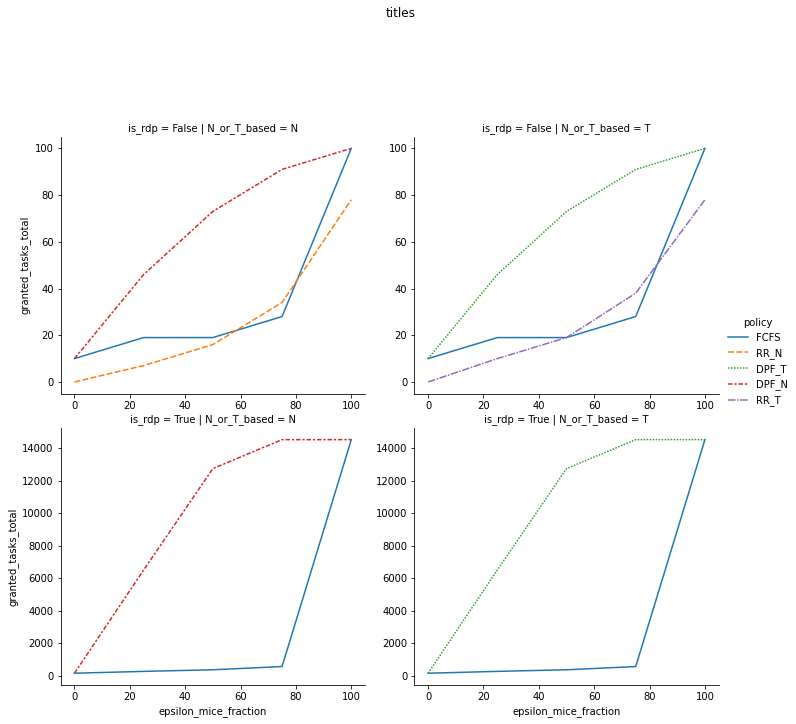

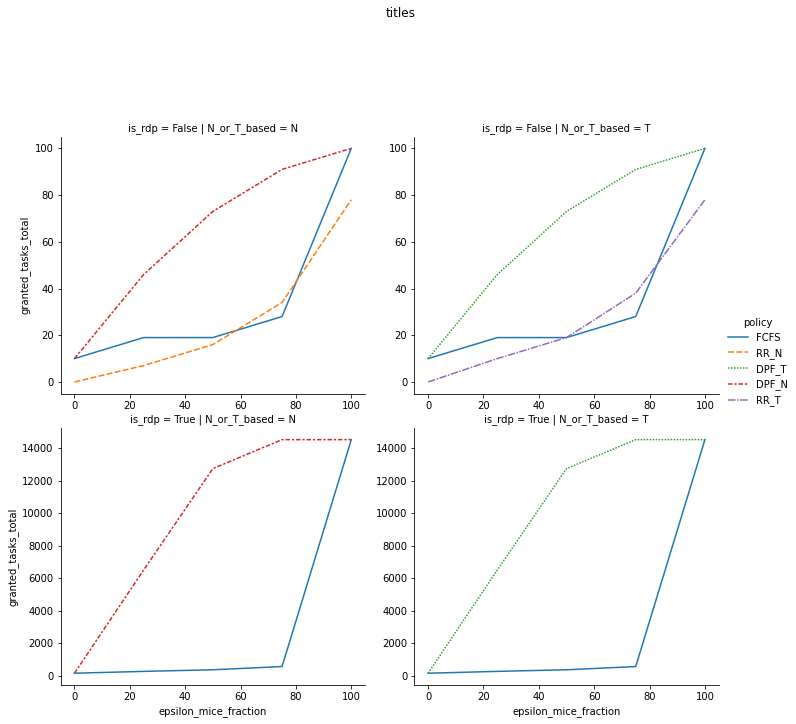

In [14]:
title = 'Number of tasks completed as function of epsilon-mice percentage '
# fix the N/T parameter for single block workload
fixed_N_or_T_dp = 125
fixed_N_or_T_rdp = 25399


is_fixed_n = lambda x: x in (-1, fixed_N_or_T_dp, fixed_N_or_T_rdp)
table2 = table.loc[table.N_.apply(is_fixed_n)]

fcfs_padding_list = []
fcfs_padding = table2[table2.policy == DpPolicyType.DP_POLICY_FCFS.value]
# left = fcfs_padding.copy()
# left.N_or_T_based = 'N'
for N_or_T_based in ('N', 'T'):
    pad_nt = fcfs_padding.copy()
    pad_nt.N_or_T_based = N_or_T_based
    fcfs_padding_list.append(pad_nt)



table2_1 = pd.concat([table2] + fcfs_padding_list, axis=0)

plot_granted_tasks(save_file_name="figure3.pdf", table=table2_1, title='titles', xaxis_col='epsilon_mice_fraction',
                   yaxis_col='granted_tasks_total')

Following graph reproduces:
 - fig 7(b) DPF with varied workload mix, single block. - Scheduling delay.
 - fig 17(b) Rényi DPF behavior with variable workload mix, single block. - Scheduling delay.


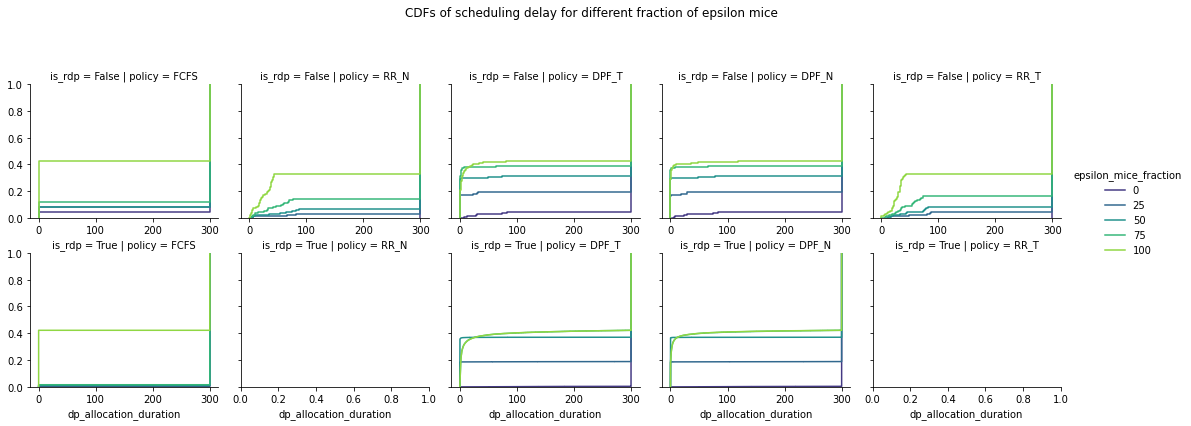

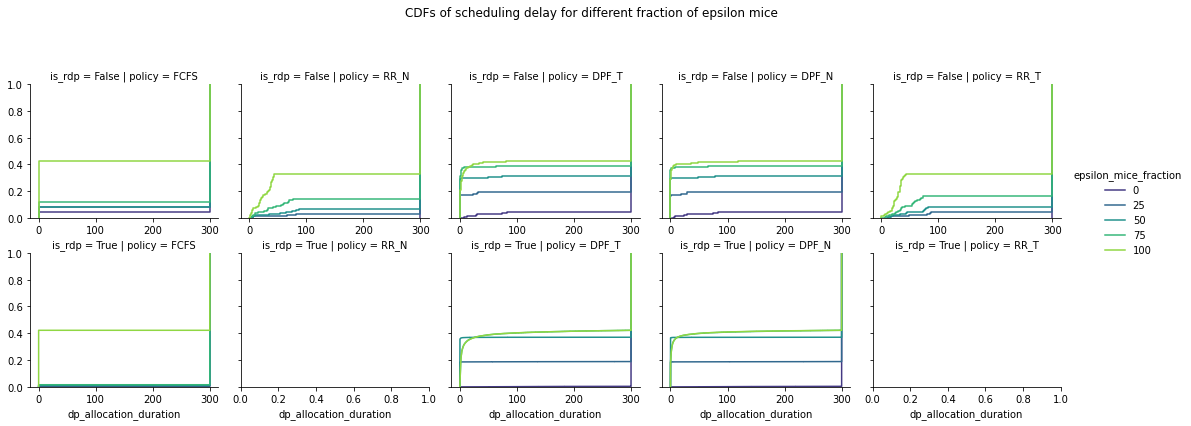

In [15]:
title = 'CDFs of scheduling delay for different fraction of epsilon mice'

plot_delay_cdf(table2, delay_lst_column, 'epsilon_mice_fraction', 'figure4.pdf', should_exclude_late_task,
               should_modify_timeout_duration=True, task_timeout=300, plot_title=title)